In [ ]:
from google_play_scraper import Sort, reviews_all
from sentence_transformers import SentenceTransformer
from sympy import false


# Fetching data

## GETTING DATA

In [ ]:
reviews = reviews_all(
    'com.makenotetoself',
    sleep_milliseconds=0,  # defaults to 0
    lang='en',  # defaults to 'en'
    country='us',  # defaults to 'us'
    sort=Sort.MOST_RELEVANT,
)

In [ ]:
import pandas as pd

## FILTERING DATA

In [ ]:
df = pd.read_csv("out_csv/reviews.csv")

In [ ]:
# df[df['repliedAt'].isna()]
df['content']

In [ ]:
df_selected = df[['content', 'score', 'thumbsUpCount']].sort_values(by='thumbsUpCount', ascending=True)
csv_filename = "out_csv/reviews.csv"
df_selected.to_csv("filtered_reviews.csv", index=False, encoding='utf-8')

In [ ]:
df = pd.read_csv("out_csv/filtered_reviews.csv")

# ANALYSIS


### CLUSTERING

In [ ]:
import os
!pip install openai



In [ ]:
from openai import OpenAI
client = OpenAI()

def get_embedding(text, model="text-embedding-3-small"):
    text = text.replace("\n", " ")
    return client.embeddings.create(input = text, model=model).data[0].embedding

df['embedding'] = df.content.apply(lambda x: get_embedding(x, model='text-embedding-3-large'))
df.to_csv('embedded_reviews.csv', index=False)

### CLUSTERING VISUALIZATION

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
import matplotlib


In [ ]:


df = pd.read_csv('out_csv/embedded_reviews.csv')
# apply(eval) интрепретирует строку как питон выражение.Если элемент столбца — это строка "[0.1, 0.2, 0.3]", то eval преобразует ее в список [0.1, 0.2, 0.3]
matrix = np.array(df.embedding.apply(eval).to_list())
print(type(matrix))
# Create a t-SNE model and transform the data
# n_components - размерность. preplexity Чем выше значение, тем больше соседей учитывается для каждой точки.
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
legend_elements = [
    Patch(facecolor='red', label='Score 1'),
    Patch(facecolor='darkorange', label='Score 2'),
    Patch(facecolor='gold', label='Score 3'),
    Patch(facecolor='turquoise', label='Score 4'),
    Patch(facecolor='darkgreen', label='Score 5')
]
plt.legend(handles=legend_elements, title="Scores")

x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.score.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, s=20, c=color_indices, cmap=colormap, alpha=0.3)
plt.tight_layout()
plt.title("Visualization of 'Note to self' Reviews")
plt.savefig('out/tsne_visualization.png', dpi=600, bbox_inches='tight')  # Save as PNG


In [ ]:
df = pd.read_csv('out_csv/embedded_reviews.csv')

matrix = np.array(df.embedding.apply(eval).to_list())

kmeans = KMeans(n_clusters=30, random_state=10)
clusters = kmeans.fit_predict(matrix)

df['cluster'] = clusters

df.to_csv('clusters_reviews.csv', index=False)

In [ ]:
df = pd.read_csv("out_csv/clusters_reviews.csv")
df[df["cluster"] == 29]['content']
# grouped = df.groupby("cluster").size()

In [ ]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

scatter = plt.scatter(vis_dims[:, 0], vis_dims[:, 1], s=20, c=clusters, cmap='viridis', alpha=0.6)
# Create legend
unique_clusters = np.unique(clusters)  # Get unique cluster labels
legend_elements = [Patch(facecolor=plt.cm.viridis(i / (len(unique_clusters) - 1)), label=f'Cluster {i + 1}') for i in unique_clusters]

plt.title("Visualization of 'Note to self' Reviews with Clusters")
plt.tight_layout()

plt.legend(handles=legend_elements, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('out/clustered_visualization.png', dpi=600, bbox_inches='tight')  # Save as PNG


### DATA ANALYSIS


In [3]:
from openai import OpenAI
import pandas as pd
client = OpenAI()


In [ ]:
res = df[df["cluster"] == 0]['content'].astype(str).str.cat(sep='\n')
print(res)


In [4]:
df = pd.read_csv('out_csv/clusters_reviews.csv')
num_of_groups = df.groupby('cluster').ngroups
results = []
for cluster_id in range(num_of_groups):
    reviews = df[df["cluster"] == cluster_id]['content'].astype(str).str.cat(sep='\n')
    prompt = f'''
    Your task is to analyze customer reviews for an Android app designed for organizing notes in a chat-like format.
    The product introduces an unconventional approach to note-taking by allowing users to create multiple chats, group them, and keep their notes within these conversations.
    You are provided with reviews for this product. In this reviews users may for example praise the product, discount it or suggest new features. In this reviews are discussed from one to three different topics. Your task is to determine from one to three topics user talk about.
    Carefully read all the responses from the survey and identify the themes and features users are discussing. Do not make anything up—base your analysis solely on the provided data.
    I’ll tip you $200 for a solid analysis and correctly identifying the theme—this is crucial for my career.
    Your response has to be only a list of identified topics. Each line in the output has start with topicName:TopicDescription
    Each review starts with the new line:
    <reviews>
    {reviews}
    </reviews>
    '''
    analyze_cluser_response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "user", "content": prompt}
        ]
    ).choices[0].message.content
    results.append(analyze_cluser_response)

with open("out/gpt_analysis#3.md", "w", encoding='utf-8') as f:
    f.writelines(map(lambda x: str(x) + "\n", results))


In [174]:
with open("out/gpt_analysis#0.md", "r", encoding="utf-8") as file:
    content = file.read()  # Read the entire file into a string

prompt = f'''
You get as an input a summarization of app reviews.
There are mentioned key themes of user reviews and features they want to add.
You task is to summarise it and get 30 most frequent different topics users write about
r.

<content>
{content}
</content>
'''
analyze_cluser_response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "user", "content": prompt}
    ]
).choices[0].message.content

with open("out/gpt_analysis_summarize#3.md", "w", encoding='utf-8') as f:
    f.write(analyze_cluser_response)


In [ ]:
with open("out/gpt_analysis#0.md", "r", encoding="utf-8") as file:
    content = file.read()  # Read the entire file into a string



with open("out/gpt_analysis_summarize#2.md", "w", encoding='utf-8') as f:
    f.write(analyze_cluser_response)


In [6]:
df = pd.read_csv("out_csv/filtered_reviews.csv")

def get_review_topic(review):
    prompt = f'''
    As input, you receive a review and a list of topics. Each topic is seperated by a new line. Each line has Topic name and it description seperated by columns. Your task is to analyze the customer review and determine which topic from the list it belongs to. You must use only the topics from the given list.

    Carefully read all the reviews and identify the most appropriate topic from the list. Do not make anything up—base your analysis solely on the provided data.
    Your response must contain only one topic from the given list. The list is ordered in descending priority, so if the review fits multiple topics, return the one with the highest priority.
    Each topic is seperated by a new line. Each line has Topic name and it description seperated by columns.
    Your response must consist only of the chosen topic name.

    I’ll tip you $200 for a correct result.
    <review>
    {review}
    </review>

    <topics>
FileSupport:Ability to attach and manage files such as PDFs and Office documents within the app.
TextFormatting:Requests for text formatting options like bold, italic, and markdown support for enhanced note customization.
WidgetsAndQuickOptions:Addition of widgets, sidebar quick options, and batch export to text for improved accessibility and efficiency.
AttachmentCapabilities:Ability to attach and save documents, photos, and other media within notes.
RemindersAndNotifications:Requests for reminder features and notifications to alert users about important notes or tasks.
MessageOrganization:Improved message management features such as pinning, reordering, and drag-and-drop functionality for better organization.
TrashBinAndCrossPlatform:Addition of a trash bin for deleted notes and requests for cross-platform syncing (Windows, iOS, web).
ThemeCustomization:Requests for theme customization, dark mode, and accessibility improvements for a personalized user experience.
NoteAlarmsAndArchiving:Features like alarms for notes, archiving options, and category differentiation for better note management.
VideoUploads:Ability to upload and manage videos within the app.
SecurityEnhancements:Requests for enhanced security features such as password protection, encryption, and authentication methods.
BackupAndSync:Automatic backups, cloud syncing, and improved backup reliability to prevent data loss.
SearchAndSorting:Search capabilities, sorting options, and advanced formatting tools for better note organization and retrieval.
User Satisfaction:Overall positive experiences with the app's functionality and innovative design.
App Crashes:Frustration with frequent crashes and app instability, particularly after updates.
Loss of Data:Concerns about losing notes and data due to the app's instability.
Emotional Expression and Reflection:App use as a tool for self-reflection and personal journaling. Assisting users, especially those with ADHD and autism, to organize thoughts.
Unique Concept:Praise for combining messaging and note-taking elements innovatively.
GeneralDiscontent:Users express overall dissatisfaction with the app, citing various issues such as crashes, data loss, poor functionality, and a lack of desired features.
    </topics>
    '''
    topic = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "user", "content": prompt}
        ]
    ).choices[0].message.content
    return topic

df['topic'] = df.content.apply(lambda x: get_review_topic(x))
df.to_csv('topic_reviews#3.csv', index=False)

In [4]:
df = pd.read_csv("out_csv/topic_reviews#3.csv")
df.groupby("topic").size()

topic
App Crashes                             63
AttachmentCapabilities                  10
BackupAndSync                           31
Emotional Expression and Reflection     26
FileSupport                              9
GeneralDiscontent                       42
Loss of Data                            36
MessageOrganization                     14
NoteAlarmsAndArchiving                  10
RemindersAndNotifications               16
SearchAndSorting                         7
SecurityEnhancements                    20
TextFormatting                          23
ThemeCustomization                      30
TrashBinAndCrossPlatform                12
Unique Concept                          51
User Satisfaction                      248
VideoUploads                             2
WidgetsAndQuickOptions                  14
dtype: int64

In [8]:
df['topic'] = df['topic'].replace('AttachmentCapabilities', 'RareFeatureRequests')
# df['topic'] = df['topic'].replace('File and Document Support: Requests for the ability to attach and save various document types (e.g., PDFs, Word files).', 'File and Document Support')
# # VideoUploads, SearchAndSorting,FileSupport, AttachmentCapabilities,


In [8]:
df.groupby("topic").size().sort_values()


topic
VideoUploads                             2
SearchAndSorting                         7
FileSupport                              9
AttachmentCapabilities                  10
NoteAlarmsAndArchiving                  10
TrashBinAndCrossPlatform                12
WidgetsAndQuickOptions                  14
MessageOrganization                     14
RemindersAndNotifications               16
SecurityEnhancements                    20
TextFormatting                          23
Emotional Expression and Reflection     26
ThemeCustomization                      30
BackupAndSync                           31
Loss of Data                            36
GeneralDiscontent                       42
Unique Concept                          51
App Crashes                             63
User Satisfaction                      248
dtype: int64

In [173]:
df[df['topic']=='Requests for Enhancements']

,content,score,thumbsUpCount,topic
3,love how simple is this but please let us scro...,4,0,Requests for Enhancements
5,Really a great application but widget will mak...,5,0,Requests for Enhancements
20,Awesome app! Hope there's plans for a Windows ...,5,0,Requests for Enhancements
23,I can't secure my notes behind a password,1,0,Requests for Enhancements
27,I love the app (got the PRO) I hope they add F...,4,0,Requests for Enhancements
...,...,...,...,...
604,Great app! It's a unique way of implementing a...,5,3,Requests for Enhancements
606,Don't update ... the new update will take off ...,1,3,Requests for Enhancements
613,This is something I've been looking for for a ...,5,4,Requests for Enhancements
632,Feature Request :- Optional sound effect on pr...,5,6,Requests for Enhancements


In [9]:
topic_weight = df.groupby('topic').agg(
    count=('topic', 'size'),
    total_thumbs=('thumbsUpCount', 'sum')
).reset_index()

topic_weight['weight'] = topic_weight['count'] + topic_weight['total_thumbs']

topic_weight = topic_weight[['topic', 'weight']]

In [16]:
topic_weight.sort_values(by='weight')

,topic,weight
17,VideoUploads,2
10,SearchAndSorting,8
4,FileSupport,11
1,AttachmentCapabilities,12
14,TrashBinAndCrossPlatform,15
18,WidgetsAndQuickOptions,17
9,RemindersAndNotifications,20
8,NoteAlarmsAndArchiving,23
7,MessageOrganization,26
3,Emotional Expression and Reflection,37


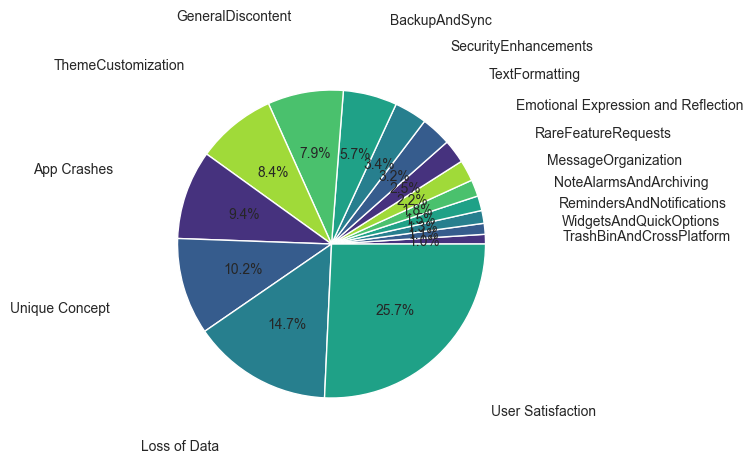

In [13]:
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    label_counts = topic_weight.sort_values(by='weight')
    label_counts.columns = ['topic', 'weight']

    # Визуализация с помощью matplotlib (круговая диаграмма)
    plt.figure(figsize=(8, 5))
    plt.pie(label_counts['weight'], labels=label_counts['topic'], autopct='%1.1f%%', colors=sns.color_palette('viridis'), labeldistance=1.5)
    plt.savefig('out/result_pie.png', dpi=600, bbox_inches='tight')



In [165]:
label_counts

,topic,weight
0,Positive User Experience,109
1,Requests for Enhancements,86
2,App Crashes,70
3,Initial Impressions,68
4,User-Friendly Design,50
5,Backup and Recovery Improvements,40
6,Other,35
7,Ease of Use,33
8,Search and Organization Tools,30
9,Unique Note Organization,24
